In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import neurkal

import itertools
from matplotlib import pyplot as plt
from matplotlib import rc, rcParams
import numpy as np
import seaborn as sns

In [3]:
## Plot style setup
#rc('mathtext', default='regular')
#rcParams.update({'figure.autolayout': True})
sns.set_style("ticks")
#set_palette = lambda: itertools.cycle(sns.color_palette("cubehelix", 8))
set_palette = lambda: itertools.cycle(sns.cubehelix_palette(8, start=2, rot=0, dark=0, light=.95, reverse=True))

In [4]:
def input_act(x, x_i):
    return 3 * (np.exp(2 * (np.cos(x - x_i) - 1)) + 0.01)

In [5]:
# simulation parameters
p = 50  # units in input networks
t_f = 10  # total time
dt = 0.1  # timestep
ts = np.arange(0, t_f, dt)

In [6]:
# dynamical parameters
M = [[1]]  # internal model dynamics
B = [[1]]   # constant "motor" dynamics
Z = [[0.00005]]  # motor noise variance
c = 0.003
c_ = np.array([[c]])

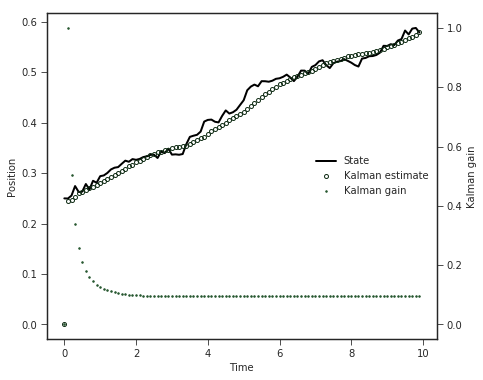

In [7]:
## test conventional kalman filter
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)
# initial state
x0 = 0.25
state = neurkal.StateDynamics(M, B, Z, x0=x0)
# sensory noise
sensory_variance = 0.005

states = []
estimates = []
gains = []
for t in ts:
    estimates.append(kalman.estimate[0, 0])
    gains.append(kalman.gain[0, 0])
    states.append(state.x[0])
    x_s = state.x + np.random.normal(0, sensory_variance)
    kalman.step(c_, x_s, Q=[[sensory_variance]])
    state.update(c_)

palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '.', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
ax2 = ax1.twinx()
ax2.set_ylabel("Kalman gain")
p3, = ax2.plot(ts, gains, '.', color=next(palette), label="Kalman gain", ms=3)

ps = [p1, p2, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

In [7]:
## Kalman network test -- only initial feedback
# initial state
x0 = 0.25
state = neurkal.StateDynamics(M, B, Z, x0=x0)

# network initialization
sensory_input = neurkal.PopCode(p, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input],
                                            motor_inputs=[], M=M, B=[[]])
# conventional kalman filter to provide sigma
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)

activities = []
hs = []
us = []
lams = []
ksigs = []

sensory_input(state.x[0])
for t in ts:
    activities.append(kalman_network.activity)
    hs.append(kalman_network._h)
    lams.append(kalman_network._lambda)
    ksigs.append(kalman.sigma)
    # update conventional kalman filter to get sigma
    kalman.step(c_, sensory_input.readout(), Q=[[sensory_input.cr_bound]])
    # update activity in basis network implementing Kalman filter
    kalman_network.update(kalman.sigma)
    us.append(kalman_network._u)
    # update real state (+ control noise)
    state.update(c_)
    if not t:
        sensory_input.clear()

prefs = kalman_network.prefs
    
palette = set_palette()
fig, ax1 = plt.subplots(figsize=(7, 6))
ax1.set_xlabel("Preferred position")
ax1.set_ylabel("Activity")
ps = []
for i in [0, 1, 2, 3]:
    ps.append(ax1.plot(prefs, activities[i], '-', color=next(palette), lw=2, label=str(i))[0])
    
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()

ValueError: shapes (50,50) and (1,50) not aligned: 50 (dim 1) != 1 (dim 0)

In [45]:
ksigs

[[[1000000000000.0]],
 array([[0.00723181]]),
 array([[0.00365336]]),
 array([[0.00247153]]),
 array([[0.00188875]]),
 array([[0.00154546]]),
 array([[0.00132178]]),
 array([[0.00116633]]),
 array([[0.00105338]]),
 array([[0.00096864]]),
 array([[0.00090352]]),
 array([[0.00085255]]),
 array([[0.00081209]]),
 array([[0.00077959]]),
 array([[0.00075325]]),
 array([[0.00073175]]),
 array([[0.00071408]]),
 array([[0.0006995]]),
 array([[0.00068742]]),
 array([[0.00067737]]),
 array([[0.00066899]]),
 array([[0.00066198]]),
 array([[0.00065611]]),
 array([[0.00065119]]),
 array([[0.00064705]]),
 array([[0.00064358]]),
 array([[0.00064065]]),
 array([[0.00063818]]),
 array([[0.0006361]]),
 array([[0.00063434]]),
 array([[0.00063286]]),
 array([[0.00063161]]),
 array([[0.00063055]]),
 array([[0.00062966]]),
 array([[0.0006289]]),
 array([[0.00062827]]),
 array([[0.00062773]]),
 array([[0.00062727]]),
 array([[0.00062688]]),
 array([[0.00062656]]),
 array([[0.00062628]]),
 array([[0.00062605]]

In [35]:
with open("test.csv", 'w') as f:
    kalman_network._w.tofile(f, sep=',')

In [38]:
kalman_network._w

array([[1.        , 0.97662171, 0.91005475, ..., 0.8100409 , 0.91005475,
        0.97662171],
       [0.97662171, 1.        , 0.97662171, ..., 0.68998877, 0.8100409 ,
        0.91005475],
       [0.91005475, 0.97662171, 1.        , ..., 0.56386015, 0.68998877,
        0.8100409 ],
       ...,
       [0.8100409 , 0.68998877, 0.56386015, ..., 1.        , 0.97662171,
        0.91005475],
       [0.91005475, 0.8100409 , 0.68998877, ..., 0.97662171, 1.        ,
        0.97662171],
       [0.97662171, 0.91005475, 0.8100409 , ..., 0.91005475, 0.97662171,
        1.        ]])

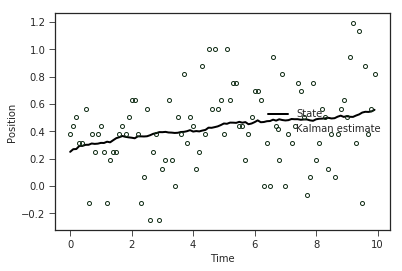

In [13]:
## Kalman network test
# initial state
x0 = 0.25
state = neurkal.StateDynamics(M, B, Z, x0=x0)

# network initialization
sensory_input = neurkal.PopCode(p, act_func=input_act,
                                dist=np.random.poisson)
# motor_input = popcode.PopCode(p, act_func=input_act, dist=lambda x: x)
kalman_network = neurkal.KalmanBasisNetwork(sensory_inputs=[sensory_input],
                                            motor_inputs=[], M=M, B=[[]])
# conventional kalman filter to provide sigma
kalman = neurkal.KalmanFilter(M=M, B=B, Z=Z)

states = []
estimates = []
gains = []

for t in ts:
    sensory_input(state.x[0])
    states.append(state.x[0])
    # update conventional kalman filter to get sigma
    kalman.step(c_, sensory_input.readout(), Q=[[sensory_input.cr_bound]])
    # update activity in basis network implementing Kalman filter
    kalman_network.update(kalman.sigma)
    estimates.append(kalman_network.readout())
    # update real state (+ control noise)
    state.update(c_)
    
palette = set_palette()
fig, ax1 = plt.subplots()#figsize=(7, 6))
ax1.set_xlabel("Time")
ax1.set_ylabel("Position")
p1, = ax1.plot(ts, states, '-', color=next(palette), label="State", lw=2)
p2, = ax1.plot(ts, estimates, '.', color=next(palette), label="Kalman estimate", markerfacecolor='none', ms=8)
#ax2 = ax1.twinx()
#ax2.set_ylabel("Kalman gain")
#p3, = ax2.plot(ts, gains, '.', color=next(palette), label="Kalman gain", ms=4)

ps = [p1, p2]#, p3]
labels = [p.get_label() for p in ps]
ax1.legend(ps, labels, loc=7)
plt.show()